# AC Optics

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from analysis import *
import glob
import re
import hvplot.xarray
font = {'family':'serif',
        'weight': 'normal',
        'size': 32}
plt.rc('font',**font)
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#000000','#e3130f','#0962f6',
                                                    '#20c168','#fc76f3','#2efef4'])
plt.rc('text',usetex=True)

In [2]:
13e-3/20e-4/4e-7/1e7

1.625

## Constants

In [2]:
mu0 = np.pi*4*1e-7
Ms = 0.93/mu0 # T
hbar = 1.055e-34
e = 1.6e-19
V = 1. #Vrms
R = 306.1 #ohms
w = 20e-4 #cm
t = 4e-7 #cm
A = w*t
I = V/R
J = I/A
tco = 1.3e-9
rho_co = 9.59e-8 #ohm m
rho_pt = 40e-8 #33.33e-8 #ohm m
R4pt = 1/(1/(rho_pt*80e-6/20e-6/4e-9) + 1/(rho_co*80e-6/20e-6/tco))
Isplit = rho_co*80e-6/20e-6/tco/(rho_pt*80e-6/20e-6/4e-9 + rho_co*80e-6/20e-6/tco)
t2xi = 2*e*Ms*tco/hbar/1e4

## OOP hyst

In [3]:
OOP = pd.read_csv('./IPC5R9_OOP_SagnacHeterodyne_V1.0000V_A0.0_2021-04-17_1.csv',comment='#')
# (m,b) = np.polyfit(OOP.sweep_field[:100],OOP.ThetaK[:100],1)
# OOP['ThetaK_corr'] = OOP['ThetaK'] - (m*OOP['sweep_field'])
OOP = OOP.set_index('sweep_field').drop(columns='elapsed_time').to_xarray()

No handles with labels found to put in legend.


1.3233776316906882


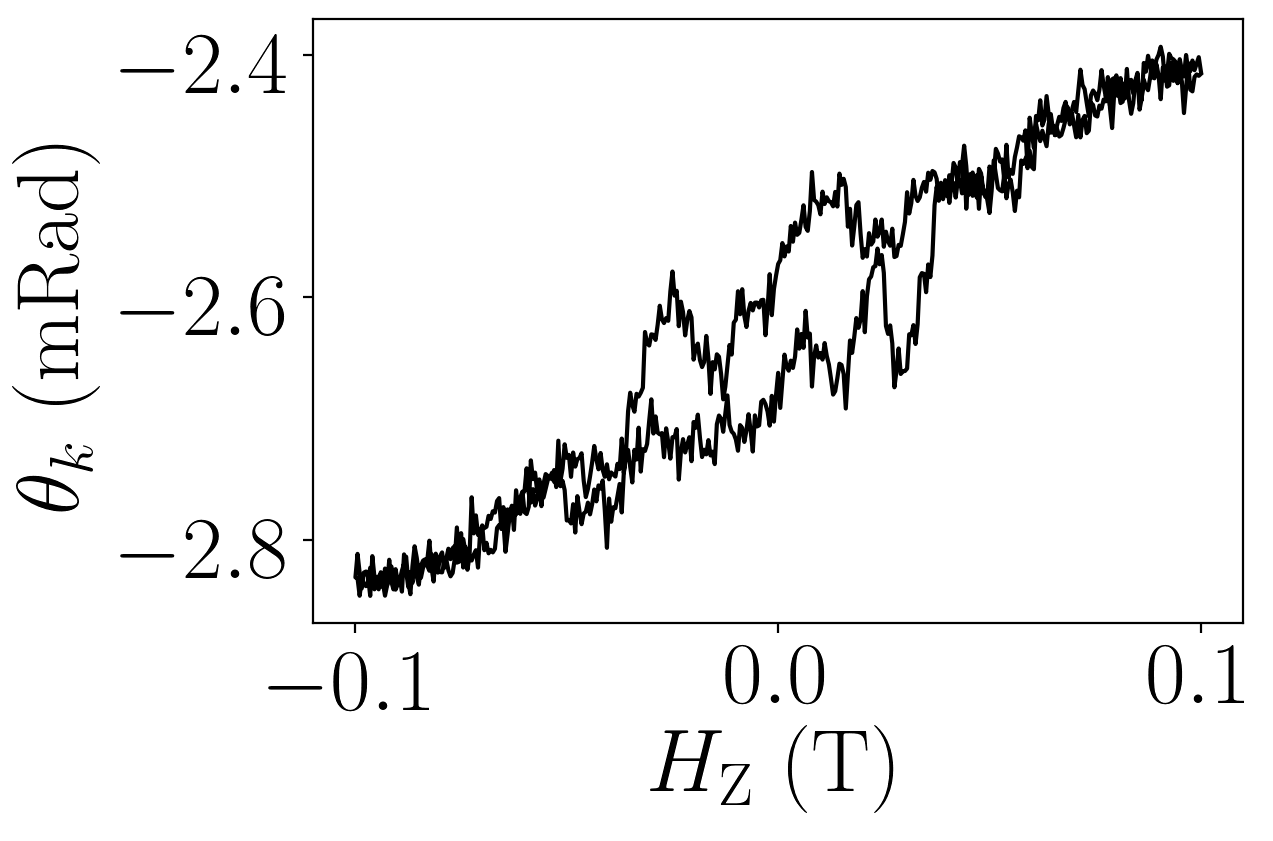

In [4]:
plt.figure(dpi=200)
plt.plot(OOP.sweep_field,OOP.ThetaK*1e3)#,label='Raw')
# plt.plot(OOP.sweep_field,OOP.ThetaK_corr*1e3,label='Corrected')
plt.ylabel('$\\theta_k$ (mRad)')
plt.xlabel('$H_{\\rm{Z}}$ (T)')
plt.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=18)
plt.xticks([-0.1,0,0.1])
(m,b) = np.polyfit(OOP.sweep_field,OOP.ThetaK,1)
kap = 0.00987/np.pi # I got this first number from the clean hysteresis of devices with stronger PMA
# the ~0.0098 is roughly the same for all of the devices on the wafer
print(1/(m/kap))
Meff = 0.05 # I estimated this from the "knee" of the second harmonic amplitudes

0.3803811290628821


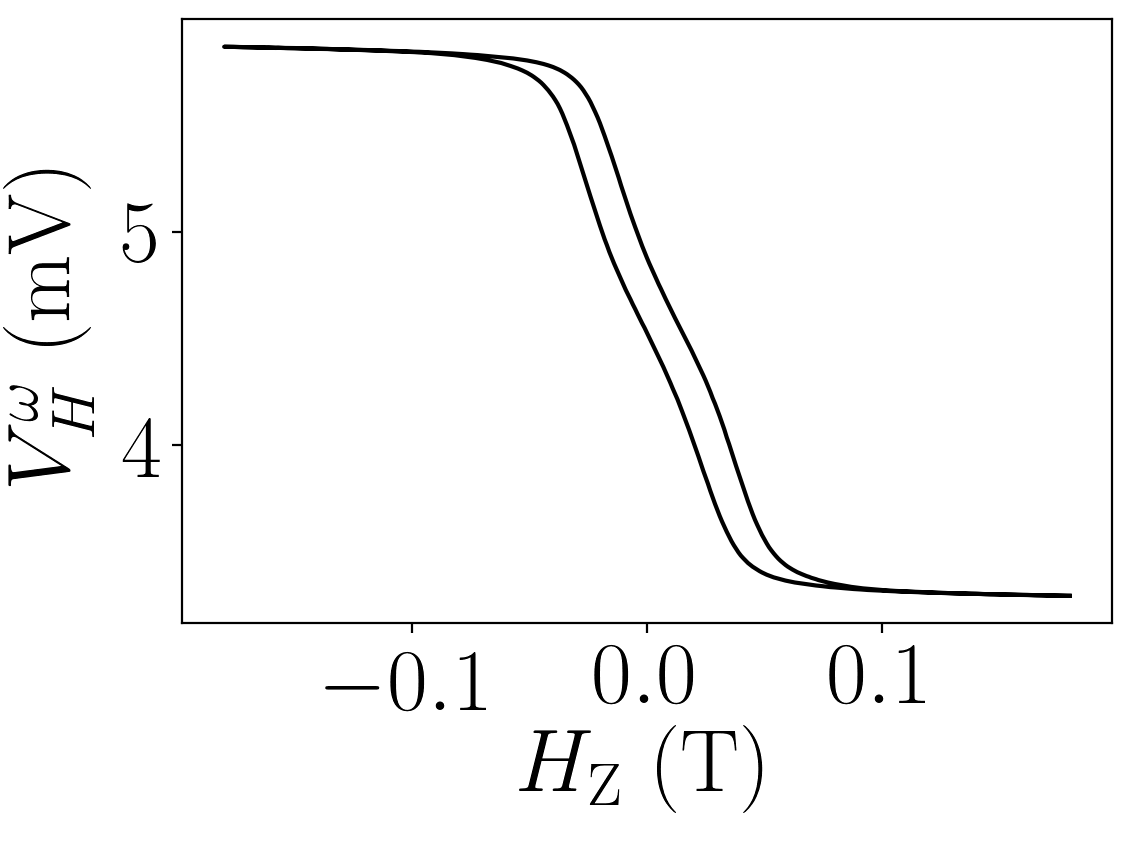

In [5]:
plt.figure(dpi=200)
AHE = pd.read_csv('./C5R9_6x6_SQUARE_AHE_HallField_P90.0_A000.0_2021-05-03_1.csv',comment='#')
plt.plot(AHE.field_strength,AHE.X1*1e3)
plt.ylabel('$V^{\\omega}_H$ (mV)')
plt.xlabel('$H_{\\rm{Z}}$ (T)')
plt.xticks([-0.1,0,0.1])
Mp = float(AHE.where(AHE.X1*1e3 > 5.5).mean().X1)
Mm = float(AHE.where(AHE.X1*1e3 < 3.5).mean().X1)
Vahe = (Mp - Mm)/2
Rahe = Vahe/I
print(Rahe) #ohms

## PHE

In [6]:
def find_field(f):
    z = re.compile('.*F(?P<B>\-?\d+\.\d+)T.*')
    return float(re.match(z,f)['B'])
def load_phe(f):
    return pd.read_csv(f,comment='#').set_index('field_azimuth').drop(columns='elapsed_time').to_xarray()
phe = combine_new_dim({find_field(f): load_phe(f) for f in glob.glob('./*PHE*V4.0V*.csv')}, 'field_strength')\
      .sortby('field_strength')
phe['DeltaThetaK'] = 2*phe['DeltaThetaK'] # one 2 to fix the PHE code which had an extra factor of 2 in it
phe['TY2'] = phe['TY2']*2 # factor of 2 because of the second harmonic mixing: Hayashi Eq (43) with our def of Rahe

In [7]:
phe.hvplot('field_azimuth','ThetaK')

:DynamicMap   [field_strength]
   :Curve   [field_azimuth]   (ThetaK)

In [8]:
phe.hvplot('field_azimuth','TX1')

:DynamicMap   [field_strength]
   :Curve   [field_azimuth]   (TX1)

In [9]:
def sin2(x,x0,a,b):
    deg2rad = np.pi/180.
    return a/2*np.sin(2*deg2rad*(x-x0)) + b
def sin2_guess(*args,**kwargs):
    return [1,1,1]
def sin(x,x0,a,b):
    deg2rad = np.pi/180.
    return a*np.sin(deg2rad*(x-x0)) + b
def sin_guess(*args,**kwargs):
    return [1,1,1]
def harm2(x,x0,a,b,c):
    deg2rad = np.pi/180.
    return a*np.cos(deg2rad*(x-x0)) + b*np.cos(deg2rad*(x-x0))*np.cos(2*deg2rad*(x-x0)) + c
def harm2_guess(*args,**kwargs):
    return [1,1,1,1]
phe_fit = fit_dataArray(phe.TX1,sin2,sin2_guess,['phi0','a','b'],'field_azimuth')
xportSOT_fit = fit_dataArray(phe.TY2,sin,sin_guess,['phi0','a','b'],'field_azimuth')
xportSOT_fit_full = fit_dataArray(phe.TY2,harm2,harm2_guess,['phi0','a','b','c'],'field_azimuth')

opSOT_fit = fit_dataArray(phe.DeltaThetaK,sin,sin_guess,['phi0','a','b'],'field_azimuth')


Text(0, 0.5, '$V_{\\rm{PHE}}$ (mV)')

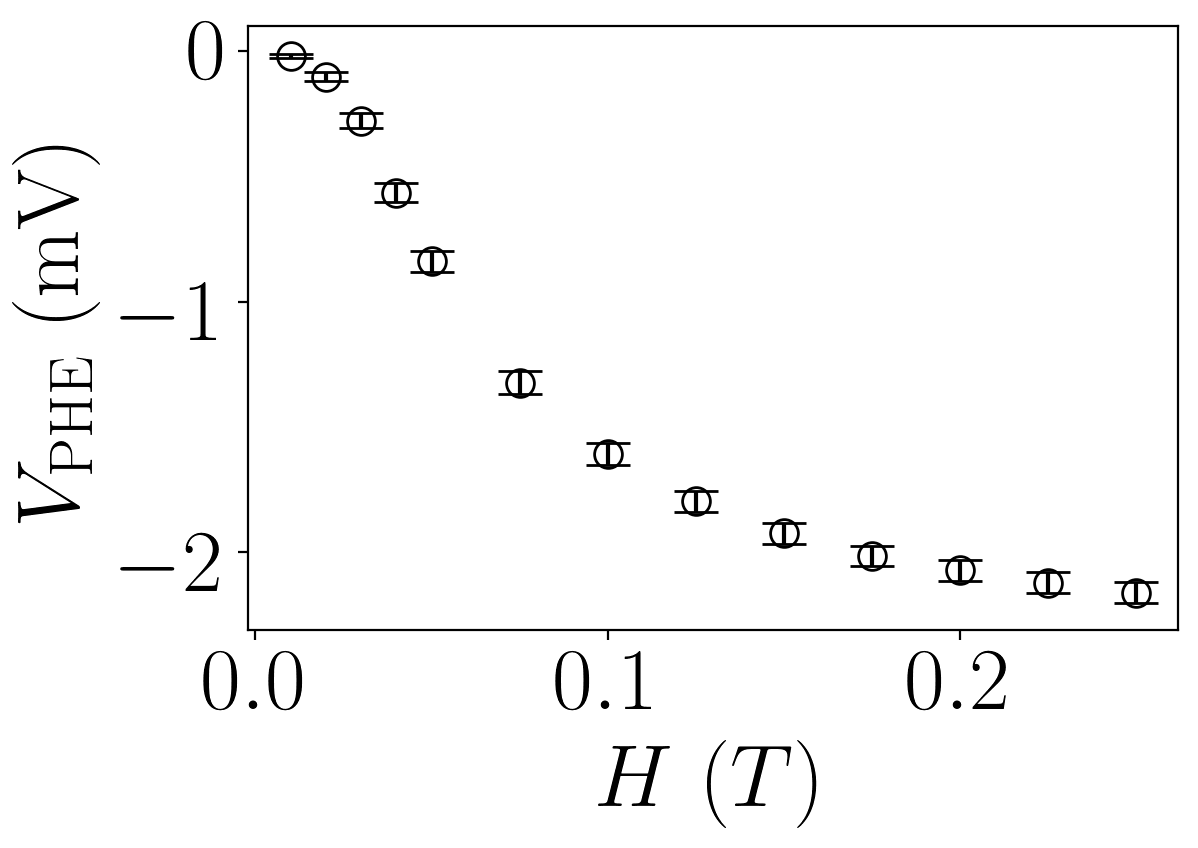

In [10]:
plt.figure(dpi=200)
plt.errorbar(phe_fit.field_strength,
             phe_fit.a*1e3,
             phe_fit.a_err*1e3,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')

plt.xlabel('$H$ ($T$)')
plt.ylabel('$V_{\\rm{PHE}}$ (mV)')


In [11]:
phe_fit.a.values[-1]/(4/R)

-0.16528391536555337

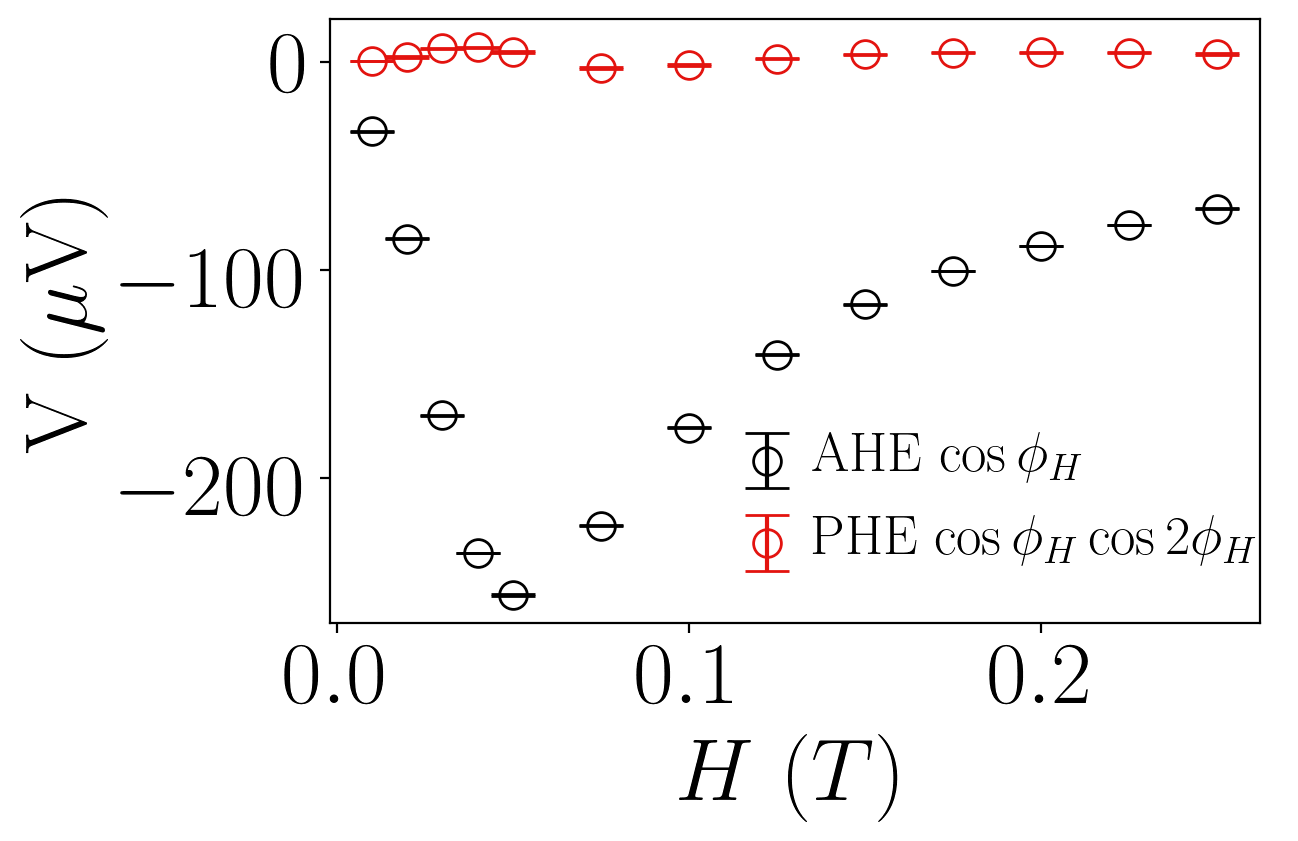

In [12]:
plt.figure(dpi=200)
plt.errorbar(xportSOT_fit_full.field_strength,xportSOT_fit_full.a*1e6,xportSOT_fit_full.a_err*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',label='AHE $\\cos\\phi_H$')
plt.errorbar(xportSOT_fit_full.field_strength,xportSOT_fit_full.b*1e6,xportSOT_fit_full.b_err*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='PHE $\\cos\\phi_H\\cos2\\phi_H$')
plt.xlabel('$H$ ($T$)')
plt.ylabel('V ($\\mu$V)')
plt.legend(loc='lower right',bbox_to_anchor=(1.05,0),ncol=1,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=20)

Text(0, 0.5, '$V_{\\rm{PHE}}/V_{\\rm{AHE}}$')

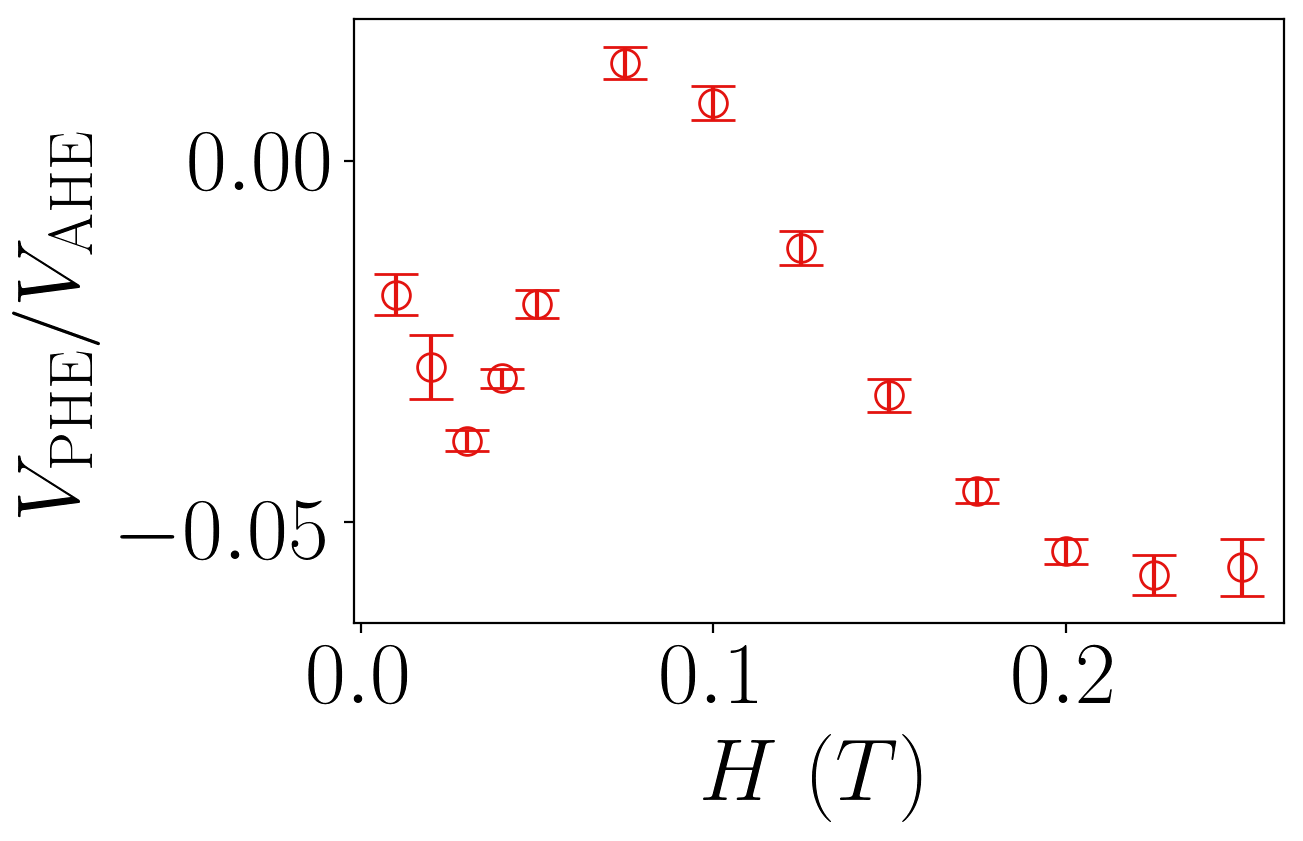

In [13]:
plt.figure(dpi=200)
# plt.errorbar(xportSOT_fit_full.field_strength,xportSOT_fit_full.a*1e6,xportSOT_fit_full.a_err*1e6,
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',label='AHE $\\cos\\phi_H$')
plt.errorbar(xportSOT_fit_full.field_strength,xportSOT_fit_full.b/xportSOT_fit_full.a,
             xportSOT_fit_full.b_err/xportSOT_fit_full.a,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='PHE $\\cos\\phi_H\\cos2\\phi_H$')
plt.xlabel('$H$ ($T$)')
plt.ylabel('$V_{\\rm{PHE}}/V_{\\rm{AHE}}$')

([<matplotlib.axis.YTick at 0x7f8db913a5d0>,
 <a list of 3 Text yticklabel objects>)

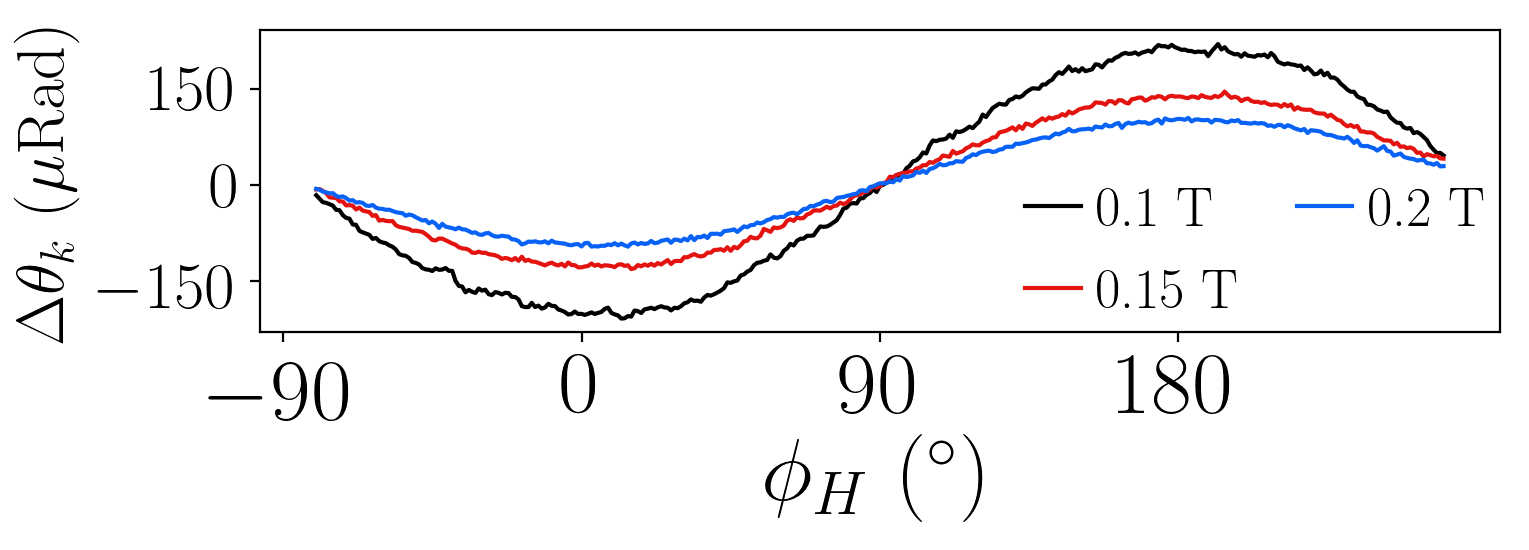

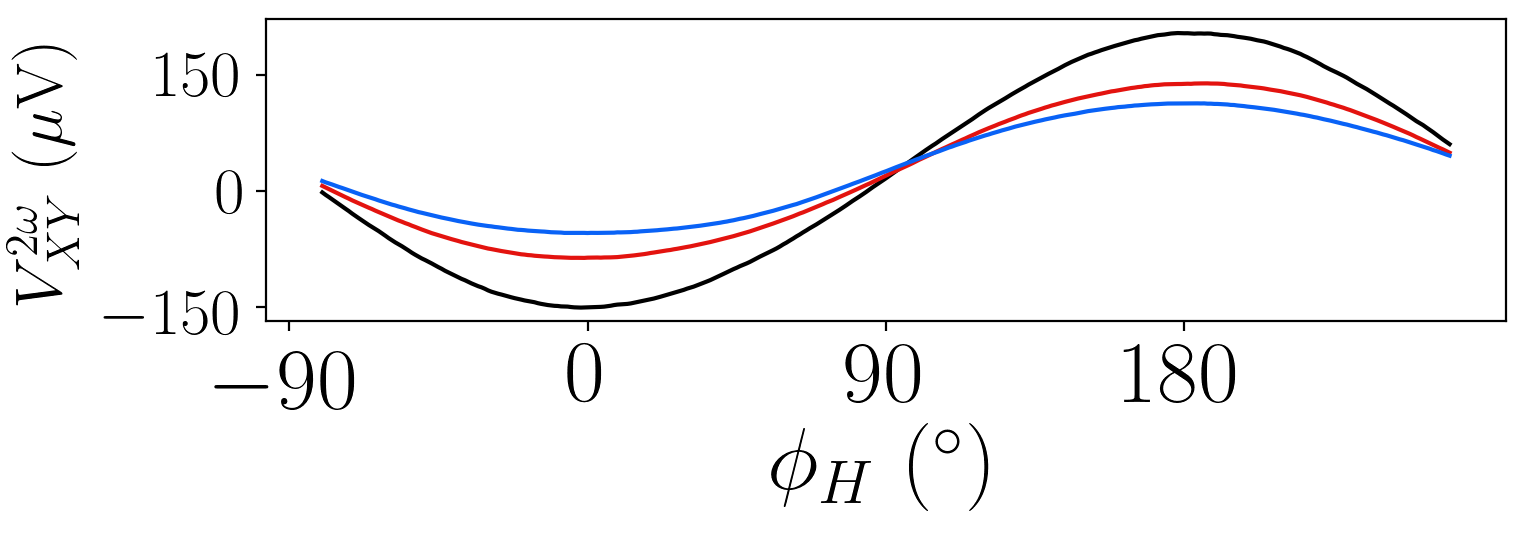

In [19]:
plt.figure(dpi=200,figsize=(8,2))
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.1).DeltaThetaK*1e6,label='0.1 T')
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.15).DeltaThetaK*1e6,label='0.15 T')
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.2).DeltaThetaK*1e6,label='0.2 T')
plt.legend(loc='lower right',bbox_to_anchor=(1.03,-0.12),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=20)
plt.xlabel('$\\phi_H$ ($^\\circ$)')
plt.xticks([-90,0,90,180])

plt.ylabel('$\\Delta\\theta_k$ ($\\mu$Rad)',fontsize=24)
plt.yticks([-150,0,150],fontsize=24)

plt.figure(dpi=200,figsize=(8,2))
# plt.plot((phe.field_azimuth+90),phe.sel(field_strength=0.2).TY2*1e6,label='0.1 T')

vphe = phe_fit.sel(field_strength=0.1).a*0.001/2/0.1*\
np.cos(np.pi/180*(phe.field_azimuth+90))*np.cos(np.pi/180*2*(phe.field_azimuth+90))

# vahe = phe_fit.sel(field_strength=0.2).a*2*0.004/2/(0.2-0.05)*\
# np.cos(np.pi/180*(phe.field_azimuth+90))

# plt.plot(phe.field_azimuth+90,vphe*1e6)
plt.plot((phe.field_azimuth+90),phe.sel(field_strength=0.1).TY2*1e6,label='1 kOe')
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.15).TY2*1e6,label='1.5 kOe')
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.2).TY2*1e6,label='2 kOe')
plt.xlabel('$\\phi_H$ ($^\\circ$)')
plt.ylabel('$V^{2\\omega}_{XY}$ ($\\mu$V)',fontsize=24)
plt.xticks([-90,0,90,180])
plt.yticks([-150,0,150],fontsize=24)

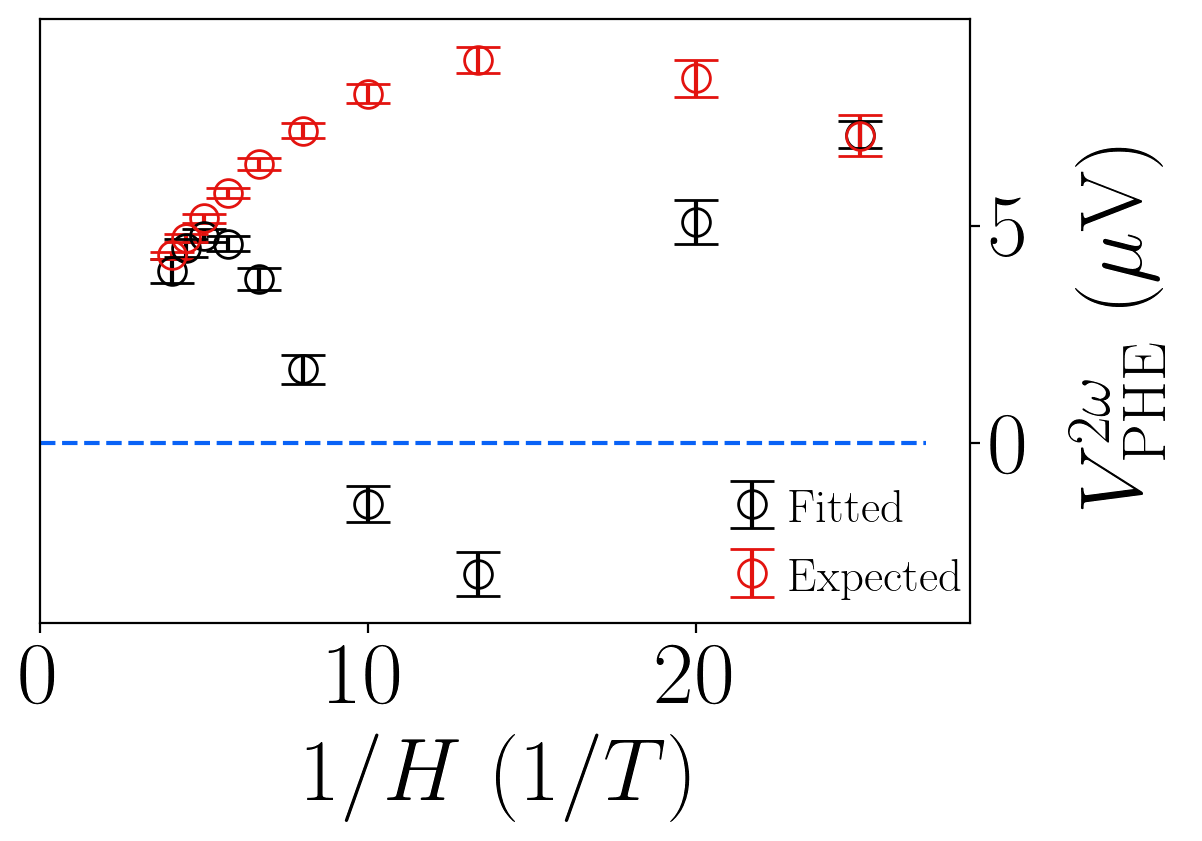

In [15]:
plt.rcParams['legend.title_fontsize'] = 'x-small'
f = plt.figure(dpi=200)
ax = f.add_subplot(111)
plt.errorbar(1/xportSOT_fit_full.field_strength.values[3:],
             xportSOT_fit_full.b.values[3:]*1e6,
             xportSOT_fit_full.b_err.values[3:]*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label = 'Fitted')
plt.errorbar(1/xportSOT_fit_full.field_strength.values[3:],
             -phe_fit.a*0.001/2/phe_fit.field_strength[3:]*1e6,
             phe_fit.a_err*0.001/2/phe_fit.field_strength[3:]*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label = 'Expected')

plt.plot([0,27],[0,0],'C2--')

plt.xlabel('$1/H$ ($1/T$)')
# plt.xticks([0,5,10])
# plt.yticks([0,200,400])

plt.xlim(0,)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.ylabel('$V^{2\\omega}_{\\rm{PHE}}$ ($\\mu$V)')
ax.yaxis.labelpad = 20
plt.legend(loc='lower right',bbox_to_anchor=(1.04,-0.03),ncol=1,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=17)

transport:  0.12681837319575254 +/- 0.00749070756863543
transport:  4.3457848573040124e-10 +/- 2.5668996299156666e-11
optics:  0.13229307784930353 +/- 0.00599307472116675
optics:  4.533390864084192e-10 +/- 2.053694012596767e-11


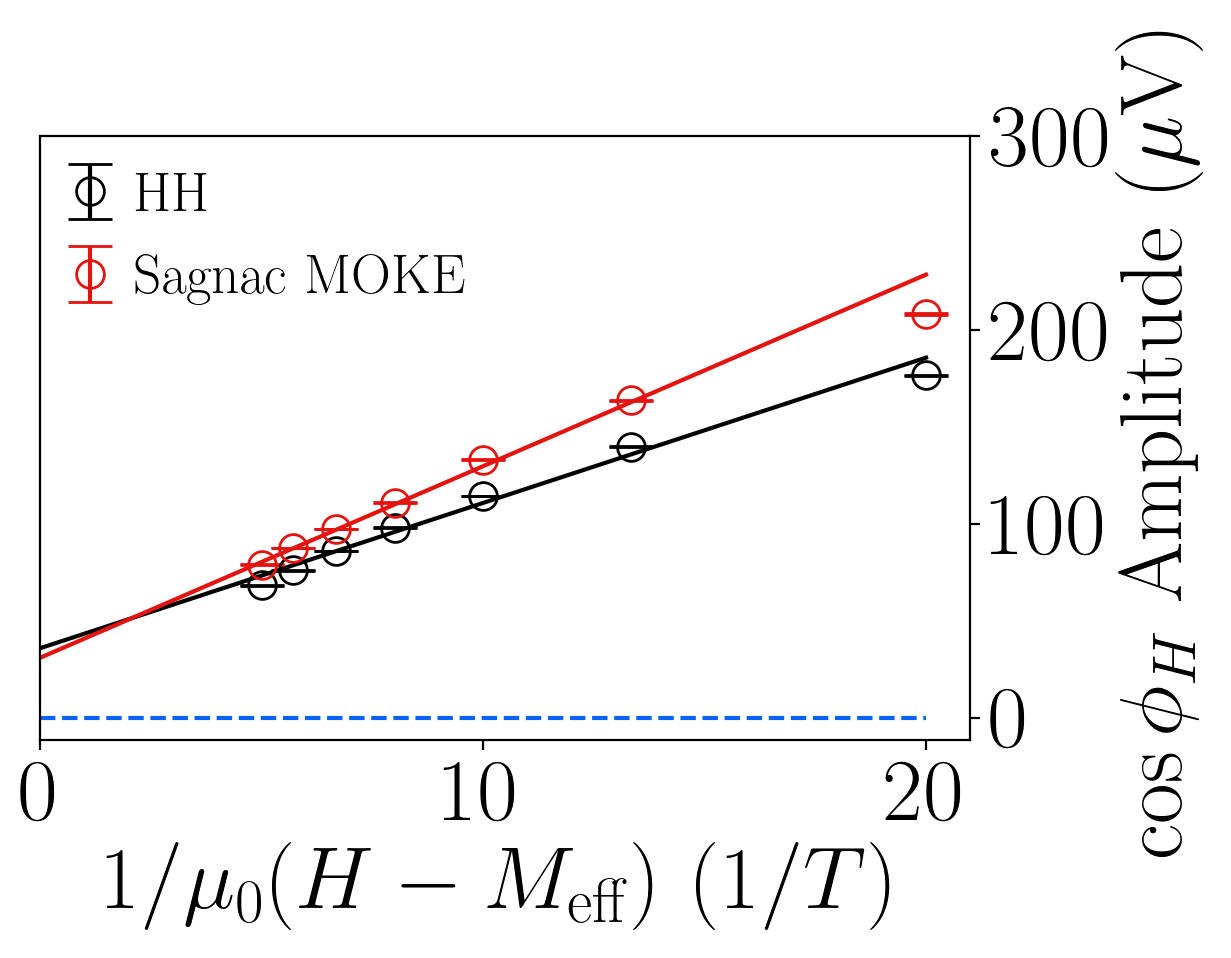

In [16]:
plt.rcParams['legend.title_fontsize'] = 'x-small'
f = plt.figure(dpi=200)
ax = f.add_subplot(111)
plt.errorbar(1/(xportSOT_fit.field_strength-Meff).values[6:],
             xportSOT_fit.a.values[6:]*1e6,
             xportSOT_fit.a_err.values[6:]*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label = 'HH')
#              label = '$V^{2\omega}_{\\rm{AHE}}$ ($\\mu$V)')

popt,pcov = np.polyfit(1/(xportSOT_fit.field_strength-Meff).values[6:],
                  xportSOT_fit.a.values[6:],1,
                  w=1/(xportSOT_fit.a_err).values[6:]**2,cov=True)
plt.plot([0,20],np.polyval(popt,[0,20])*1e6)
print("transport: ", 2*popt[0]/(4/R/A*Isplit)/(Rahe*4/R)*t2xi,'+/-',
                     2*np.sqrt(np.diag(pcov)[0])/(4/R/A*Isplit)/(Rahe*4/R)*t2xi)
print("transport: ", 2*popt[0]/(4/R/A*Isplit)/(Rahe*4/R),'+/-',
                     2*np.sqrt(np.diag(pcov)[0])/(4/R/A*Isplit)/(Rahe*4/R))

plt.errorbar(1/(opSOT_fit.field_strength-Meff).values[6:],
             opSOT_fit.a.values[6:]*1e6,
             opSOT_fit.a_err.values[6:]*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label = 'Sagnac MOKE')
#              label = '$\\Delta\\theta_k^0$ ($\\mu$rad)')
popt,pcov = np.polyfit(1/(opSOT_fit.field_strength-Meff).values[6:],
                  opSOT_fit.a.values[6:],1,
                  w=1/(opSOT_fit.a_err).values[6:]**2,cov=True)
plt.plot([0,20],np.polyval(popt,[0,20])*1e6)
print("optics: ", popt[0]/(4/R/A*Isplit)/kap*t2xi,'+/-', np.sqrt(np.diag(pcov)[0])/(4/R/A*Isplit)/kap*t2xi)
print("optics: ", popt[0]/(4/R/A*Isplit)/kap,'+/-', np.sqrt(np.diag(pcov)[0])/(4/R/A*Isplit)/kap)


# plt.errorbar(1/(xportSOT_fit_full.field_strength-Meff).values[6:],
#              xportSOT_fit_full.b.values[6:]*1e6,
#              xportSOT_fit_full.b_err.values[6:]*1e6,
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C2',
#              label = '$V^{2\omega}_{\\rm{PHE}}$ ($\\mu$V)')

plt.plot([0,20],[0,0],'C2--')

plt.xlabel('$1/\\mu_0(H-M_{\\rm{eff}})$ ($1/T$)')
# plt.xticks([0,5,10])
plt.yticks([0,100,200,300])
plt.ylabel('$\\cos\\phi_H$ Amplitude ($\\mu$V)')

plt.xlim(0,)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.legend(loc='upper left',bbox_to_anchor=(-0.03,1.03),ncol=1,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=20)

In [17]:
3.9287607260768875e-10*1e6*1e3

0.39287607260768875

In [18]:
4/R

0.01306762495916367